In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json
/kaggle/input/dm-2024-isa-5810-lab-2-homework/sampleSubmission.csv
/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv
/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv


# BERT 太 .... 太穩健，不夠敏感 ?
- 為了更好地處理語言的多樣性和口語化表達，且對噪音的適應性強
- 只能加寫一隻 RoBERTa 演算法程式
- RoBERTa (蘿菠塔)
- https://arxiv.org/abs/1907.11692

# 1. 資料清理 , 把 無效標籤 拿掉
# 2. 開始執行 RoBERTa

In [2]:
import json
import re
import pandas as pd
import os
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler

# 定義清理推文文本的函數
def clean_tweet(text):
    # 移除 <LH> 標籤
    text = re.sub(r'<LH>', '', text)
    # 移除多餘的空白字元
    text = text.strip()
    return text

# 讀取推文資料
data1 = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data1.append(json.loads(line))

# 轉換為 DataFrame 並提取相關欄位
df = pd.DataFrame(data1)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})

# 清理文本
df['text'] = df['text'].apply(clean_tweet)

# 讀取附加資料
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

# 合併資料
df = df.merge(data_identification, on='tweet_id', how='left')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

train_data = train_data.merge(emotion, on='tweet_id', how='left')
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

# 分割數據集
X_train, X_val, y_train, y_val = train_test_split(
    train_data['text'], train_data['emotion'], test_size=0.2, random_state=42, stratify=train_data['emotion']
)

# 標籤編碼
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# 計算類別權重
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ======== PyTorch Dataset 定義 ========
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 初始化 RoBERTa Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_len = 128

# DataLoader，使用 num_workers=0 防止多進程問題
train_loader = DataLoader(
    TweetDataset(pd.Series(X_train), y_train, tokenizer, max_len),
    batch_size=64, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    TweetDataset(pd.Series(X_val), y_val, tokenizer, max_len),
    batch_size=64, num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    TweetDataset(test_data['text'], [0] * len(test_data), tokenizer, max_len),
    batch_size=64, num_workers=0, pin_memory=True
)

# ======== 模型與優化器 ========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 包裝模型以支持多 GPU
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', num_labels=len(le.classes_)
)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model = model.to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scaler = torch.amp.GradScaler()

# 學習率調度器
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=int(len(train_loader) * 0.1), num_training_steps=len(train_loader) * 3
)

# ======== 訓練與驗證函數 ========
def train_epoch(model, data_loader, criterion, optimizer, scaler, device, scheduler):
    model.train()
    losses = []
    all_preds = []
    all_labels = []

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):  # 修正過時警告
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return np.mean(losses), f1

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with torch.amp.autocast(device_type='cuda'):  # 修正過時警告
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

            losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return np.mean(losses), f1

# 訓練過程
epochs = 4
best_f1 = 0
patience = 2
early_stop_counter = 0

for epoch in range(epochs):
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, scaler, device, scheduler)
    val_loss, val_f1 = eval_model(model, val_loader, criterion, device)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

    if val_f1 > best_f1:
        best_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.module.state_dict(), 'best_model.pth')  # 保存多 GPU 模型權重
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# 測試資料預測
model.module.load_state_dict(torch.load('best_model.pth'))  # 加載多 GPU 模型權重
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())

test_data['emotion'] = le.inverse_transform(test_predictions)
submission = test_data[['tweet_id', 'emotion']]
submission.to_csv('/kaggle/working/submission.csv', index=False)

print('Submission saved successfully!')


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/4
Train Loss: 1.2659, Train F1: 0.5556
Val Loss: 1.1230, Val F1: 0.6006


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 2/4
Train Loss: 1.0577, Train F1: 0.6205
Val Loss: 1.0774, Val F1: 0.6265


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 3/4
Train Loss: 0.9430, Train F1: 0.6473
Val Loss: 1.0876, Val F1: 0.6327


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 4/4
Train Loss: 0.8900, Train F1: 0.6590
Val Loss: 1.0876, Val F1: 0.6327


/tmp/ipykernel_23/30837402.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load('best_model.pth'))  # 加載多 GPU 模型權重
/opt/conda/lib/py

Submission saved successfully!


In [4]:
# 修改列名為 'id' 和 'emotion'
submission = test_data[['tweet_id', 'emotion']]
submission.columns = ['id', 'emotion']  # 這行將列名改為 'id' 和 'emotion'

# 保存為 CSV 檔案
submission.to_csv('/kaggle/working/submission.csv', index=False)

print('Submission saved successfully!')

Submission saved successfully!


# 3. 執行分析

In [5]:
submission.head()

,id,emotion
2,0x28b412,anticipation
4,0x2de201,trust
9,0x218443,joy
30,0x2939d5,anticipation
33,0x26289a,trust


## 3.1 針對本次 (5. RoBERTa + Transformer + clean) 訓練結果作分析

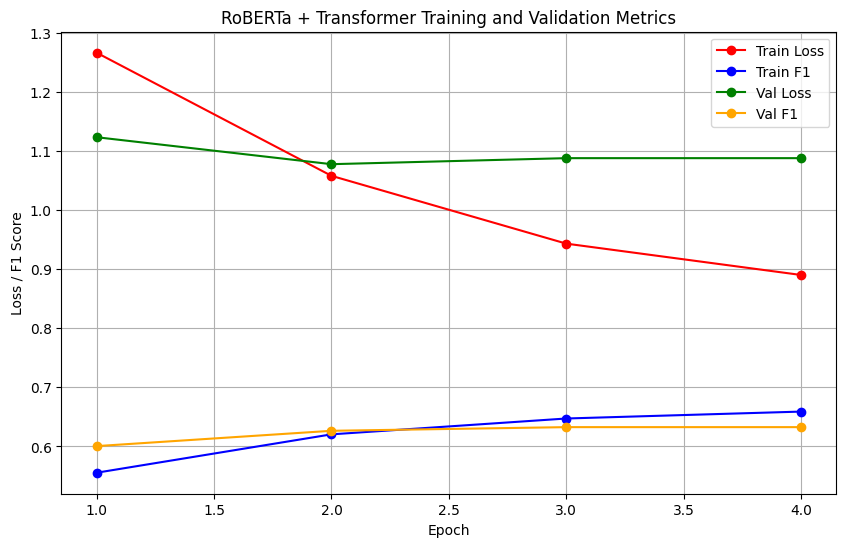

In [7]:
import matplotlib.pyplot as plt

# Data for the RoBERTa + Transformer training results
epochs = [1, 2, 3, 4]
train_loss = [1.2659, 1.0577, 0.9430, 0.8900]
train_f1 = [0.5556, 0.6205, 0.6473, 0.6590]
val_loss = [1.1230, 1.0774, 1.0876, 1.0876]
val_f1 = [0.6006, 0.6265, 0.6327, 0.6327]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
# Plot train F1
plt.plot(epochs, train_f1, label='Train F1', color='blue', marker='o')
# Plot val loss
plt.plot(epochs, val_loss, label='Val Loss', color='green', marker='o')
# Plot val F1
plt.plot(epochs, val_f1, label='Val F1', color='orange', marker='o')

# Add title and labels
plt.title('RoBERTa + Transformer Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Loss / F1 Score')

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()


### 這是針對 RoBERTa + Transformer 的訓練與驗證結果的折線圖，包含以下指標：
- 紅色線條：訓練損失（Train Loss），隨著訓練次數逐漸下降。
- 藍色線條：訓練 F1 分數（Train F1），隨著訓練次數逐漸上升。
- 綠色線條：驗證損失（Val Loss），下降到一定程度後趨於穩定。
- 橙色線條：驗證 F1 分數（Val F1），逐步提升並趨於穩定。

## 3.2 最後兩次結果比較

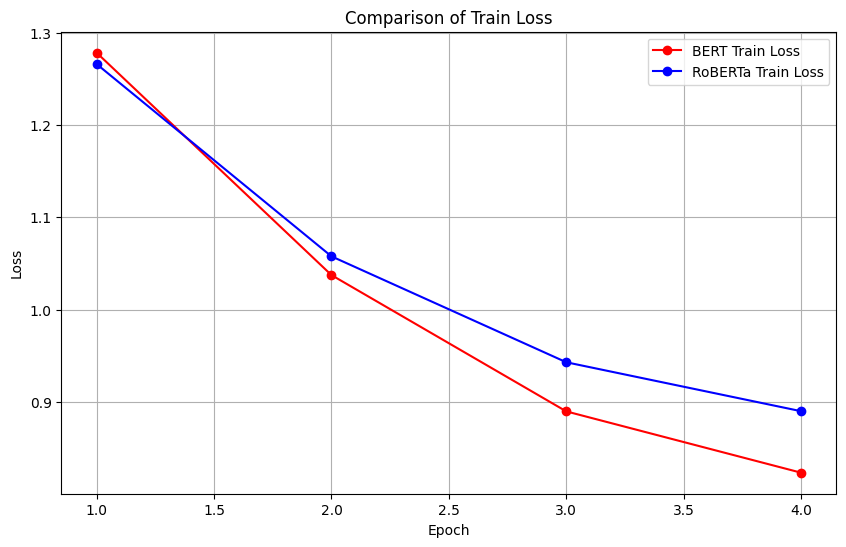

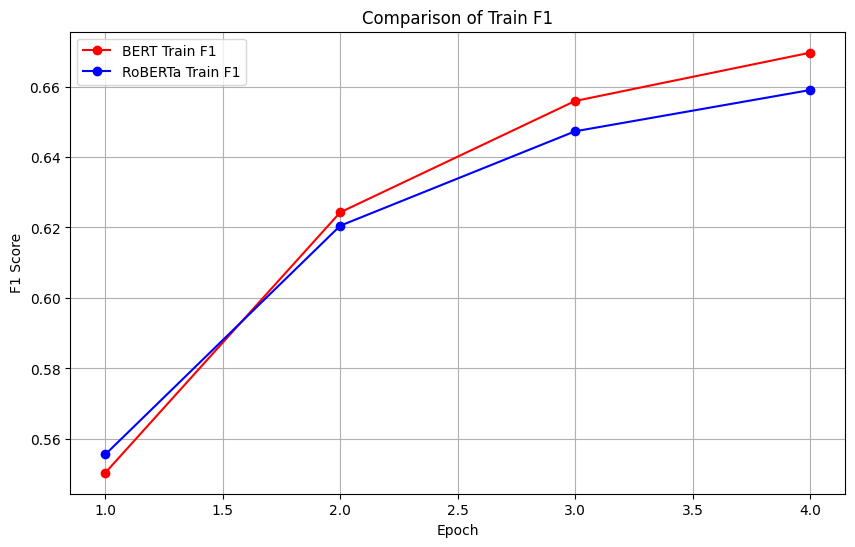

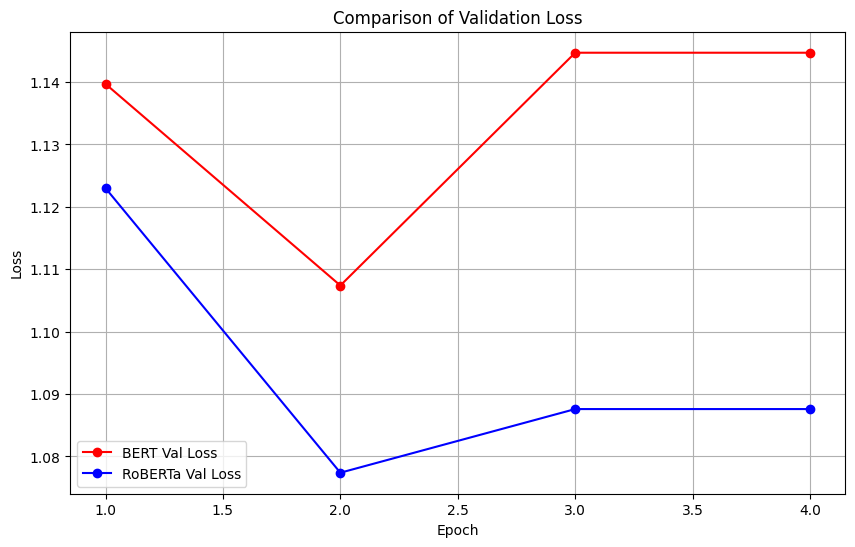

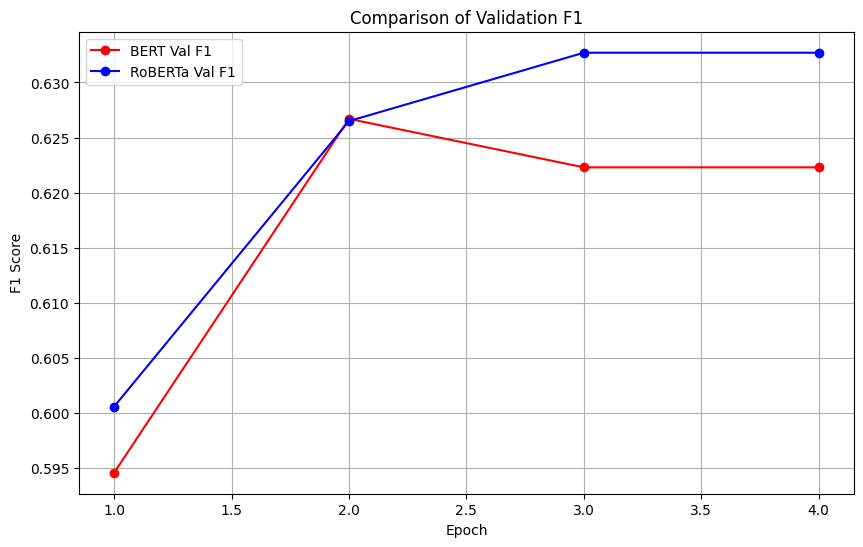

In [8]:
# Data for BERT + Transformer training results
bert_train_loss = [1.2782, 1.0374, 0.8898, 0.8234]
bert_train_f1 = [0.5504, 0.6243, 0.6559, 0.6696]
bert_val_loss = [1.1397, 1.1074, 1.1447, 1.1447]
bert_val_f1 = [0.5946, 0.6267, 0.6223, 0.6223]

# Data for RoBERTa + Transformer training results
roberta_train_loss = [1.2659, 1.0577, 0.9430, 0.8900]
roberta_train_f1 = [0.5556, 0.6205, 0.6473, 0.6590]
roberta_val_loss = [1.1230, 1.0774, 1.0876, 1.0876]
roberta_val_f1 = [0.6006, 0.6265, 0.6327, 0.6327]

# Epochs
epochs = [1, 2, 3, 4]

# Plot comparison of train loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, bert_train_loss, label='BERT Train Loss', color='red', marker='o')
plt.plot(epochs, roberta_train_loss, label='RoBERTa Train Loss', color='blue', marker='o')
plt.title('Comparison of Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot comparison of train F1
plt.figure(figsize=(10, 6))
plt.plot(epochs, bert_train_f1, label='BERT Train F1', color='red', marker='o')
plt.plot(epochs, roberta_train_f1, label='RoBERTa Train F1', color='blue', marker='o')
plt.title('Comparison of Train F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot comparison of val loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, bert_val_loss, label='BERT Val Loss', color='red', marker='o')
plt.plot(epochs, roberta_val_loss, label='RoBERTa Val Loss', color='blue', marker='o')
plt.title('Comparison of Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot comparison of val F1
plt.figure(figsize=(10, 6))
plt.plot(epochs, bert_val_f1, label='BERT Val F1', color='red', marker='o')
plt.plot(epochs, roberta_val_f1, label='RoBERTa Val F1', color='blue', marker='o')
plt.title('Comparison of Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


## 這些折線圖分別呈現了 BERT + Transformer 與 RoBERTa + Transformer 的訓練與驗證結果比較：

### 1. 訓練損失比較：
- BERT 的訓練損失下降稍快，但最終與 RoBERTa 的表現接近。
- RoBERTa 起始損失稍低，但下降速度較平緩。

### 2. 訓練 F1 比較：
- 兩者的訓練 F1 都隨著 Epoch 增加逐步提升，最終 RoBERTa 略低於 BERT。

### 3. 驗證損失比較：
- RoBERTa 的驗證損失略低於 BERT，且較為穩定。
- BERT 的驗證損失在後期稍有波動。

### 4. 驗證 F1 比較：
- RoBERTa 的驗證 F1 表現稍優於 BERT，特別是在前幾個 Epoch。
- RoBERTa 最終趨於穩定，而 BERT 表現略有下降。

## 總結 : RoBERTa + Transformer 優於 BERT + Transformer

## 3.3 混淆矩陣、分類報告、精確度計算

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


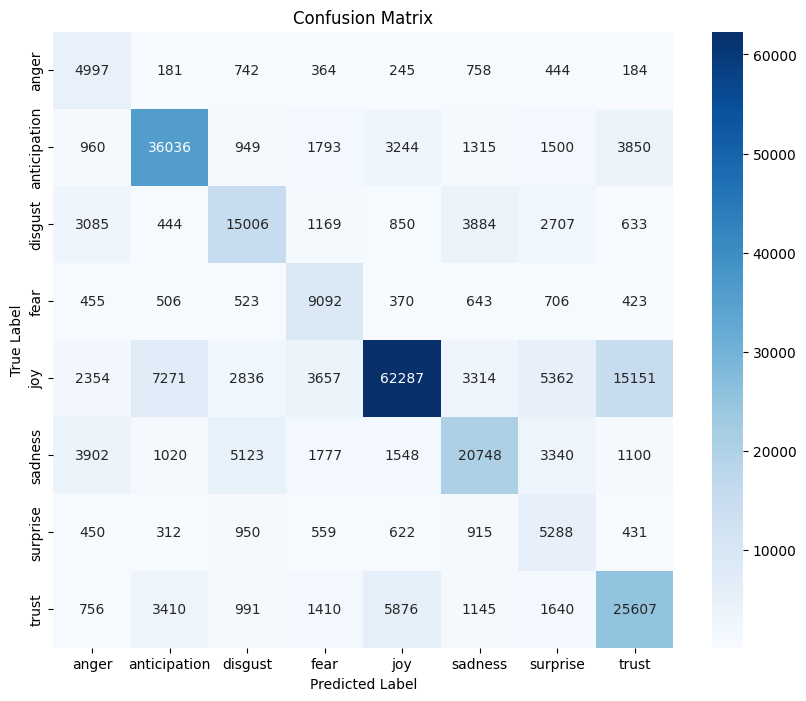

Confusion Matrix:
[[ 4997   181   742   364   245   758   444   184]
 [  960 36036   949  1793  3244  1315  1500  3850]
 [ 3085   444 15006  1169   850  3884  2707   633]
 [  455   506   523  9092   370   643   706   423]
 [ 2354  7271  2836  3657 62287  3314  5362 15151]
 [ 3902  1020  5123  1777  1548 20748  3340  1100]
 [  450   312   950   559   622   915  5288   431]
 [  756  3410   991  1410  5876  1145  1640 25607]]

Classification Report:
              precision    recall  f1-score   support

       anger       0.29      0.63      0.40      7915
anticipation       0.73      0.73      0.73     49647
     disgust       0.55      0.54      0.55     27778
        fear       0.46      0.71      0.56     12718
         joy       0.83      0.61      0.70    102232
     sadness       0.63      0.54      0.58     38558
    surprise       0.25      0.56      0.35      9527
       trust       0.54      0.63      0.58     40835

    accuracy                           0.62    289210
   macr

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 預測驗證集資料
model.eval()
val_predictions = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        val_predictions.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# 計算混淆矩陣
cm = confusion_matrix(val_labels, val_predictions)
accuracy = accuracy_score(val_labels, val_predictions)

# 1. 畫出混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 2. 列出混淆矩陣
print("Confusion Matrix:")
print(cm)

# 3. 做出分類報告
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions, target_names=le.classes_))

# 4. 印出 Accuracy
print(f"\nValidation Accuracy: {accuracy:.4f}")